In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

In [2]:
def gillespie_abc(N_A0, k1, k2, t_end):
    """
    Gillespie algorithm for A -> B -> C.
    Returns arrays of (times, N_A, N_B, N_C).
    """
    N_A, N_B, N_C = N_A0, 0, 0
    t = 0.0

    times = [t]
    A_hist = [N_A]
    B_hist = [N_B]
    C_hist = [N_C]

    while t < t_end:
        a1 = k1 * N_A  # propensity: A -> B
        a2 = k2 * N_B  # propensity: B -> C
        a0 = a1 + a2

        if a0 == 0:
            break

        # time to next event
        tau = np.random.exponential(1.0 / a0)
        t += tau
        if t > t_end:
            break

        # select which event fires
        if np.random.rand() < a1 / a0:
            N_A -= 1
            N_B += 1
        else:
            N_B -= 1
            N_C += 1

        times.append(t)
        A_hist.append(N_A)
        B_hist.append(N_B)
        C_hist.append(N_C)

    return np.array(times), np.array(A_hist), np.array(B_hist), np.array(C_hist)

In [3]:
# deterministic ODE solution for comparison
def ode_rhs(t, y, k1, k2):
    A, B = y
    return [-k1 * A, k1 * A - k2 * B]

k1, k2 = 1.0, 0.5
N_A0 = 50
t_end = 8.0

sol = solve_ivp(ode_rhs, [0, t_end], [N_A0, 0], args=(k1, k2),
                dense_output=True, max_step=0.01)
t_det = np.linspace(0, t_end, 500)
A_det, B_det = sol.sol(t_det)
C_det = N_A0 - A_det - B_det

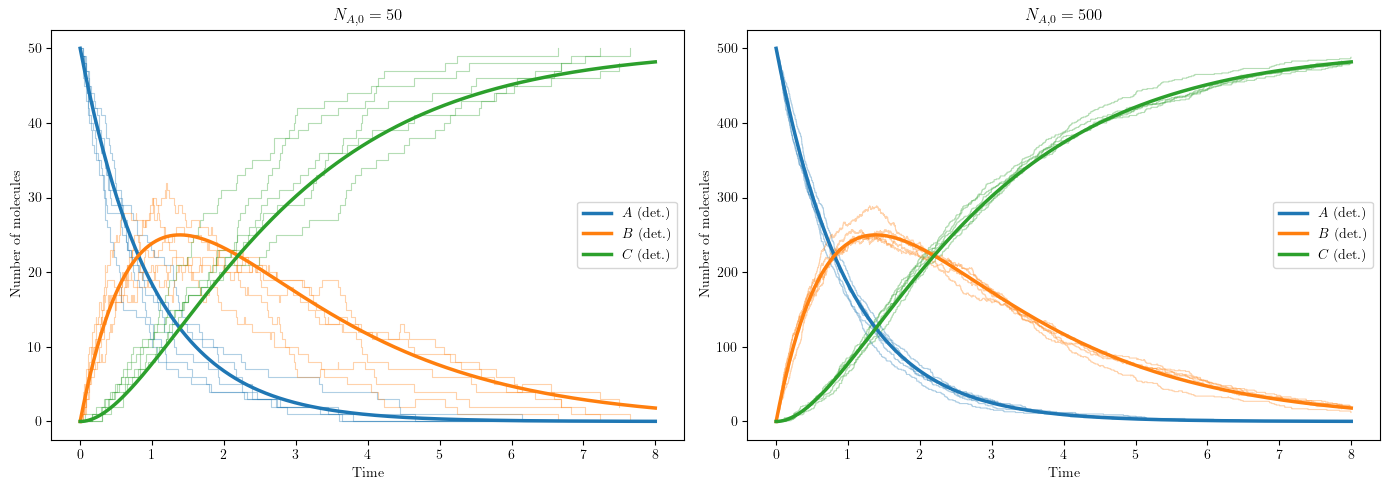

In [ ]:
np.random.seed(42)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# left panel: a few stochastic trajectories vs. deterministic
ax = axes[0]
colors = {'A': 'C0', 'B': 'C1', 'C': 'C2'}

for i in range(5):
    ts, As, Bs, Cs = gillespie_abc(N_A0, k1, k2, t_end)
    alpha = 0.35
    ax.step(ts, As, where='post', color=colors['A'], alpha=alpha, lw=0.8)
    ax.step(ts, Bs, where='post', color=colors['B'], alpha=alpha, lw=0.8)
    ax.step(ts, Cs, where='post', color=colors['C'], alpha=alpha, lw=0.8)

ax.plot(t_det, A_det, color=colors['A'], lw=2.5, label=r'$A$ (det.)')
ax.plot(t_det, B_det, color=colors['B'], lw=2.5, label=r'$B$ (det.)')
ax.plot(t_det, C_det, color=colors['C'], lw=2.5, label=r'$C$ (det.)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of molecules')
ax.set_title(r'$N_{A,0} = 50$')
ax.legend()

# right panel: larger system where fluctuations become negligible
ax = axes[1]
N_A0_large = 500
sol_large = solve_ivp(ode_rhs, [0, t_end], [N_A0_large, 0], args=(k1, k2),
                      dense_output=True, max_step=0.01)
A_det_l, B_det_l = sol_large.sol(t_det)
C_det_l = N_A0_large - A_det_l - B_det_l

for i in range(5):
    ts, As, Bs, Cs = gillespie_abc(N_A0_large, k1, k2, t_end)
    ax.step(ts, As, where='post', color=colors['A'], alpha=alpha, lw=0.8)
    ax.step(ts, Bs, where='post', color=colors['B'], alpha=alpha, lw=0.8)
    ax.step(ts, Cs, where='post', color=colors['C'], alpha=alpha, lw=0.8)

ax.plot(t_det, A_det_l, color=colors['A'], lw=2.5, label=r'$A$ (det.)')
ax.plot(t_det, B_det_l, color=colors['B'], lw=2.5, label=r'$B$ (det.)')
ax.plot(t_det, C_det_l, color=colors['C'], lw=2.5, label=r'$C$ (det.)')
ax.set_xlabel('Time')
ax.set_ylabel('Number of molecules')
ax.set_title(r'$N_{A,0} = 500$')
ax.legend()

plt.tight_layout()
plt.savefig('../../../figs/monte-carlo/kmc_trajectories.pdf', bbox_inches='tight')
plt.show()